# ACSE 7 Data Assimilation assessment

_Expected completion time:_
- Part I: less than 30 minutes
- Part II: less than 2 hours 30 minutes

The forced one-dimensional viscous Burgers' equation occurs frequently in fluid dynamics and acoustics. In form it is very similar to the Navier-Stokes equations you saw in ACSE-3,

$$ \frac{\partial u}{\partial t} +u\frac{\partial u}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

Here $u$ is the variable of interest, $z$ is the independent variable representing space in the domain and $r(z)$ is a given forcing term. For numerical convenience it is also common to write the advective term $u\frac{\partial u}{\partial z}$ in a conservative form,
$$ \frac{\partial u}{\partial t} +\frac{1}{2}\frac{\partial u^2}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

You have been provided with observational data of $u$ for a number of time levels at $z=5$ and $z=-5$ from a Burger's model system in a periodic domain of period 20. In the region $[-10, 10]$ $r(z)$ takes the form $100\sin\left(\frac{3t}{8}\right)\exp(-100z^2)$.

## Part I

Consider the following potential data assimilation strategies:

- Multiple 4D-Var assimilation events
- Multiple OI assimilation events
- A single OI assimilation
- A single 4D-Var assimilation
- Multiple iterations of the ordinary Kalman filter
- Multiple 3D-Var assimialtion events

Place the six possible strategies in order from most appropriate to least appropriate in order to generate an accurate forcast at the time $t=100$. For each strategy include a _short_ (i.e one paragraph or less) explanation of why you have placed it where you have.

#### Insert answer here

Most appropriate
  1. Multiple 4D-Var assimilation events:compared with single 4D-Var OI， single method is less accurate. Because multiple events can split the time domain into several sections( or windows),and in each section we can assimilate data and the process of assimilating is not affected by the former section. So multiple events is more accurate than single event.
  2. A single 4D-Var assimilation: 4D-Var turns the Kalman Filter into a logically consistant problem which includes the nonlinearities present in the real world, and which can be attacked by existing optimization techniques.4D-Var can solves the nolinear problem campared with Kalman Filter.**And in this coursework the Burgers' equation with force item is a nonlinear PDE, so using 4D-Var is more accurate than Kalman Filter.**
  3. Multiple iterations of the ordinary Kalman filter:compared with 3D-Var, Kalman filter takes timesteps into account.
  4. Multiple 3D-Var assimialtion events: In 3D-Var there is no data selection, all available data are used simultaneously, and the cost function os minimized using global minimization algorithms and as a result it makes unnecessary many of the simplifying approximation required by OI. So it more accurate than OI method. 
  5. Multiple OI assimilation events： compared with 3D-Var, OI assimilation is the least appropriate,because by OI method requires the introduction of a number of approximations,and local solutions of the analysis,grid points by grid points. It also requires selection of only the stations cloest to the grid point being analyzed.
  6. A single OI assimilation：compared with multiple OI， single method is less accurate. Because multiple events can split the time domain into several sections( or windows),and in each section we can assimilate data and the process of assimilating is not affected by the former section. So multiple events is more accurate than single event.Finally, compared with other methods OI assimilation is the least appropriate,because by OI method requires the introduction of a number of approximations,and local solutions of the analysis,grid points by grid points. It also requires selection of only the stations cloest to the grid point being analyzed.
  
Least appropriate

<!--  $x_t + u\cdot\nabla x = 4*k \nabla^2 x^2$ -->

## Part II

You may assume that the observations are independent, with Gaussian errors with standard deviation 0.05 (at $z=-3$ ) and 0.1 (at $z=3$). The supplied observational data and background error covariance matrix can be loaded using the following code block:

In [1]:
# observations data is in array form y[timelevel, location]
# where location 0 is z=-5 and location 1 is z=5
#
# The actual time value is stored in the t_obs array

import numpy as np
data = np.load('burgers_observations.npz')
t_obs = data['t_obs']
y = data['y']

# B is the (sparse) background error covariance matrix

def generate_B_matrix(z):
    B = np.empty([len(z), len(z)])
    
    for _ in range(len(z)):
        B[_, :] = 0.2**2*np.exp(-4*(z[_]-z)**2)*((z[_]-z)**2<=4)
    return B

In [2]:
print(t_obs)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79]


- Implement your best data assimilation strategy to provide a forecast at $t=100$ for an initial background at $t=0$ of $u=1$ (i.e $x_b$=1) using the observations, background error covariance matrix and observation statistices provided. 
- Write a short (i.e three paragraph or less) description of your method, and of any potential issues that it will not be able to cope with.

For your convenience, you may use the following forecast model, or write your own.


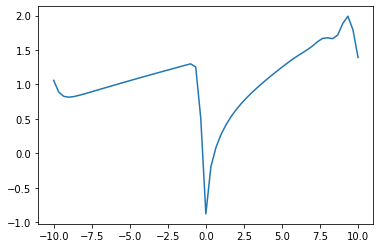

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv

z = np.linspace(-10, 10, 61)
dz = z[1]-z[0]
u = np.full(z.shape, 1.0)
# print(u)
nu = 0.4
dt = 0.05

B = generate_B_matrix(z)

## Use forward Euler for the (nonlinear) advection  and Crank-Nicolson for diffusion
def rhs(U, dt, t):
    out = np.empty(U.shape)
    out[0] = U[0]-0.5*dt/dz*(U[1]**2-U[-1]**2-nu*(U[-1]-2*U[0]+U[1])/dz)
    out[1:-1] = U[1:-1]-0.5*dt/dz*(U[2:]**2-U[:-2]**2-nu*(U[:-2]-2*U[1:-1]+U[2:])/dz)
    out[-1] = U[-1]-0.5*dt/dz*(U[0]**2-U[-2]**2-nu*(U[-2]-2*U[-1]+U[0])/dz)
    
    return out+dt*10*np.sin(.375*np.pi*(t+0.5*dt))*np.exp(-100*z**2)

def lhs_matrix(u, dt):
    mat = np.eye(u.shape[0])
    mat[0,-1] -= 0.5*dt*nu/dz**2
    mat[0, 0] += dt*nu/dz**2
    mat[0, 1] -= 0.5*dt*nu/dz**2
    for _ in range(1, u.shape[0]-1):
        mat[_, _-1] -= 0.5*dt*nu/dz**2
        mat[_, _] += dt*nu/dz**2
        mat[_, _+1] -= 0.5*dt*nu/dz**2
    mat[-1,-2] -= 0.5*dt*nu/dz**2
    mat[-1, -1] += dt*nu/dz**2
    mat[-1, 0] -= 0.5*dt*nu/dz**2
    return mat

def burgers_equation(u0, dt, t_final):
    t = 0.0
    u = u0
    out = [u0]
    mat = lhs_matrix(u0, dt)
    matinv = inv(mat)
    while t<t_final:
        for _ in range(10):
            u = matinv.dot(rhs(u, dt, t))
            t += dt
        out.append(u)
    return out

data = burgers_equation(u, dt, 100)
plt.plot(z, data[-1]);

### Adjoint model
PDE MODEL:
$$ \frac{\partial u}{\partial t} +\frac{1}{2}\frac{\partial u^2}{\partial z} = \nu \frac{\partial^2 u}{\partial z^2} +r(z).$$

First substitute $u \rightarrow  u+\delta u$, then we get:
$$  \frac{\partial (u+\delta u)}{\partial t} +\frac{1}{2}\frac{\partial (u+\delta u)^2}{\partial z} = \nu \frac{\partial^2 (u+\delta u)}{\partial z^2} +r(z)
$$

$$  \frac{\partial u}{\partial t}+\frac{\partial \delta u}{\partial t}+\frac{1}{2}(\frac{\partial u^2}{\partial z}+\frac{\partial 2(u\delta u)}{\partial z}+\frac{\partial (\delta u)^2}{\partial z}) = \nu \frac{\partial^2 u}{\partial z^2}+\nu \frac{\partial^2 (\delta u)}{\partial z^2} +r(z)
$$

Simplifying the equation, we can get:
$$  \frac{\partial \delta u}{\partial t} + \frac{\partial (u\delta u)}{\partial z}= \nu \frac{\partial^2 \delta u}{\partial z^2}
$$

$$
\frac{\partial (u\delta u)}{\partial z} = u\frac{\partial \delta u}{\partial z} + \delta u\frac{\partial u}{\partial z}
$$ 

This turn into the continuous cost function in an integral:
$$ \int\lambda(\frac{\partial \delta u}{\partial t}+ \frac{\partial (u\delta u)}{\partial z}- \nu \frac{\partial^2 \delta u}{\partial z^2})d\Omega dt
$$

$$ \int\delta u(\frac{\partial \lambda}{\partial t}+ \frac{\partial (u\lambda)}{\partial z}- \nu \frac{\partial^2 \lambda}{\partial z^2})d\Omega dt
$$

So we can get continuous adjoint equation:
$$
\frac{\partial \lambda}{\partial t}= -\frac{\partial (u\lambda)}{\partial z}+ \nu \frac{\partial^2 \lambda}{\partial z^2}
$$

Discretizing in time (backward order):
$$
\lambda_{k} = \lambda_{k+1} - \Delta t( -\frac{\partial (u_{k+1}\lambda_{k+1})}{\partial z}+ \nu \frac{\partial^2 \lambda_{k+1}}{\partial z^2})
$$

Discretizing in space:
$$
u_{k+1}^{i} = u_{k}^{i} + \Delta t \left[ -\frac{1}{2}\frac{(u_{k}^{i+1})^2-(u_{k}^{i-1})^2}{2\Delta z} + \nu \frac{u_{k}^{i+1} -2u_{k}^{i} +u_{k}^{i-1}}{\Delta z^2} \right]
$$

Playing the linearization trick again, we can get:
$$
\delta u_{k+1}^{i} = \delta u_{k}^{i} + \Delta t \left[ -u_{k}^{i} \frac{\delta u_{k}^{i+1}-\delta u_{k}^{i-1}}{2\Delta z} - \delta u_{k}^{i}\frac{ u_{k}^{i+1}- u_{k}^{i-1}}{2\Delta z} +\nu \frac{\delta u_{k}^{i+1} -2 \delta u_{k}^{i} +\delta u_{k}^{i-1}}{\Delta z^2}  \right]
$$

From the equation above, we can get the tangent linear model $u_{k+1} = M u_{k} $:

$$
M = \left[
\begin{matrix}
 1-\frac{u_{k}^1 \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}    & -\frac{u_{k}^{0} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}   & 0  & 0   & \cdots & 0      \\
 \frac{\Delta t u_{k}^1}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^2 - u_{k}^0) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{1} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}  & 0   & \cdots & 0      \\
 0 &\frac{\Delta t u_{k}^2}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2}      & 1-\frac{(u_{k}^3 - u_{k}^1) \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2}  & -\frac{u_{k}^{2} \Delta t} {2\Delta z}+\frac{\nu\Delta t}{\Delta z^2}    & \cdots & 0      \\
 \cdots & \ddots & \ddots & \ddots  & \ddots  & \cdots \\
  0  & 0    & 0 &0 &\frac{\Delta t u_{k}^{n-1}}{2\Delta z}+\frac{\Delta t \nu}{\Delta z^2} & 1+\frac{u_{k}^{n-2} \Delta t}{2\Delta z}-\frac{2\nu\Delta t}{\Delta z^2} 
\end{matrix}
\right]
$$

In [50]:
num_u = 61
u0 = u

nt = 100 / (10 * dt) + 1 + 1
nt = int(nt)
print(nt)
Binv = inv(B)

# construct matrix R
R = np.zeros((y.shape[1],y.shape[1]))
R[0,0] = 0.05 ** 2
R[1,1] = 0.1 ** 2

# construct h
h = np.zeros((y.shape[1], z.size))

h[0,15] = 1  # z = -5
h[1,45] = 1 # z = 5



x = burgers_equation(u0, dt, 100)
x = np.array(x)
x_b = np.ones(x.shape[1])
lamdaN = h.T @ np.linalg.inv(R) @ (y[-1,:] - h @ x[-1])

# construct M
M = np.zeros((z.size,z.size))
M = np.eye(z.size)
for i in range(z.size-1):
    M[i,i+1] = dt * nu / dz**2
    M[i+1,i] = dt * nu / dz**2

for i in range(z.size):
    M[i,i] = - 2 * dt * nu / dz**2


202


In [51]:
# 求 lambdas ，拉格朗日乘数
def adjoint_model(x, y, h):
    """
    x : result of burgers equation
    """
    lamda = h.T @ np.linalg.inv(R) @ (y[-1,:] - h @ x[-1])
    nt = y.shape[0]
    for t in range(1, int(nt)):
        tmp = M.copy()
        for i in range(z.size-1):
            tmp[i,i+1] -= dt*x[-t-1,i] / 2 / dz
            tmp[i+1,i] += dt*x[-t-1,i + 1] / 2 / dz
        for i in range(1,z.size-1):
            tmp[i,i] = (x[-t-1,i+1] - x[-t-1,i-1]) * dt / 2 / dz
        tmp[0,0] += x[-t-1,1] * dt / 2 / dz
        tmp[-1,-1] += x[-t-1,-2] * dt / 2 / dz
        
        lamda = tmp.T @ lamda - h.T @ np.linalg.inv(R) @ (y[-t-1,:] - h @ x[-t-1])
        
    return lamda

In [52]:
### Define the 4DVar cost function

def j(x0, y, h):
    x = burgers_equation(u0, dt, 100)
    x = np.array(x)
    j_b0 = 0.5*(x0-x_b).dot(Binv.dot((x0-x_b)))
    j_b = j_b0
    for _ in range(80):
        j_b += 0.5*np.sum((y[_,:] - h @ x[_]).T@np.linalg.inv(R) @ (y[_,:] - h @ x[_]))
    return j_b

### And the function giving the gradient with respect to x_0

def jac(x0, y, h):
    x = burgers_equation(u0, dt, 100)
    x = np.array(x)
    jac= Binv.dot(x0-x_b) + adjoint_model(x, y, h)
    return jac

In [53]:
%matplotlib inline
from matplotlib import pyplot as p

[ 1.77688396e-08  3.47920076e-07 -1.82071835e-06 -3.06986032e-05
 -8.80466412e-05 -3.74627550e-04 -1.55137666e-03  3.37680313e-03
  4.45089922e-03 -2.64691448e-03  1.22360492e-01 -8.99059455e-03
 -3.35509286e+00 -1.28186936e+00  4.27112233e+00 -9.85584722e+01
  9.96199947e-01 -9.24548440e-02 -7.33040696e-02 -1.99529374e-05
  3.33288031e-04  4.29721092e-06  1.07574976e-06  7.04544213e-07
 -9.75252880e-08 -4.41821359e-09 -2.60726752e-12  1.69033130e-10
  1.54833279e-09  1.25823872e-08  3.40198586e-08  5.63442200e-08
 -8.34989903e-07 -6.85610762e-06 -4.68985475e-06  8.94447904e-05
  6.06693273e-04  4.74143681e-04 -2.50918105e-03  7.02098592e-04
 -4.28044525e-02 -1.28582847e-01  2.16917144e-01 -1.01011858e+01
 -1.76425599e+01  3.17298298e+01 -1.17272076e+01 -1.39310618e-01
  1.59551033e-03 -4.32216009e-04 -4.58072051e-05  9.59853319e-07
  1.94824013e-07  3.91007418e-08  4.89935503e-08  3.33924647e-09
  7.11019054e-11 -4.24748093e-11 -1.14229745e-12  1.38672453e-14
  5.14479560e-16]
2.10743

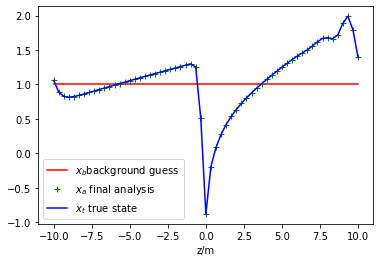

In [54]:
# 4D var implementation for a diffusion problem with swarth observational data
from scipy.optimize.linesearch import line_search_armijo as line_search

### iterate with a basic linesearch to minimise the cost function and generate the 
### analysis state.

x_a = x_b.copy()
j0 = j(x_a, y, h)
for _ in range(100):
    pk = -jac(x_a, y, h)
    print(pk)
    res = line_search(j, x_a, pk, -pk, j0, args=(y, h), alpha0=1)
    print(res[0])
    x_a += res[0]*pk
    j0 = res[2]
    if res[0]<0.001:
        break
print(x_a)

j0 = jac(x_b, y, h)

### Now plot some figures

print('Cost function for $x_b$', j(x_b, y, h))
print('Cost function for $x_a$', j(x_a, y, h))


x_f = burgers_equation(x_a,dt,100)

fig = p.figure()
ax = fig.add_subplot(111)
ax.plot(z,x_b,'-r',label='$x_{b}$background guess')
ax.plot(z,x_f[-1],'+g',label='$x_{a}$ final analysis')
ax.plot(z,x[-1],'b',label='$x_{t}$ true state')
ax.set_xlabel('z/m')
ax.legend()


